The log of testing: https://wandb.ai/mlteamaau/Machine_learning_project?workspace=user-qfaithencz

In [ ]:
# @title import everything what we need and even more
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

import json
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix,classification_report
import torch
import torch.nn as nn
import os
from sklearn.model_selection import train_test_split
torch.manual_seed(0)

# @title import wandb
!pip install wandb
import wandb
wandb.login()
from tqdm import tqdm

#choose the device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


device(type='cuda')

# **Define block - define function to load the data and create model classes - Linear regression, MLP, CNN, LeNet**

In [ ]:

# @title Load the data from google drive -> Image (numpy array data type - fload), labels (numpy array data type - fload) and classes | Function definition (load_data)
def load_data(path ,show=True, MNIST = True, A_Z = True):
  # import everything what we need and even more
  import numpy as np
  import pandas as pd
  import matplotlib.pyplot as plt
  import seaborn as sns

  col = ["label"]
  for i in range(28*28):
    col.append(i)

  # import dataframe
  digits = pd.read_csv(f"{path}/mnist_train.csv", names=col)
  letters = pd.read_csv(f"{path}/A_Z Handwritten Data.csv",names = col,low_memory=False)
  letters["label"] = letters["label"].apply(lambda x: x + 10)
  # shift letters to 10 now A - 10 and Z - 35


  #copy digits dataframe to df and del digits, we don't have enough memory at least me
  # df - the whole set which contains digits (0..9) and letters (A(10)..Z(35))

  #take only 2000 samples for each letter and put them to df
  # again memory .....(
  df = pd.concat([digits[digits['label'] == 0][0:2000]])
  for i in range(1,10,1):
    df = pd.concat([df,digits[digits['label'] == i][0:2000]])
  for i in range(10,36,1):
    df = pd.concat([df,letters[letters['label'] == i][0:2000]])
  classes = []
  for i in range(10):
    classes.append(f"{i}")
  for i in range(10,36,1):
    classes.append(f"{chr(65 + i - 10)}")


  # split label and images
  labels = df['label']
  images = df.drop(['label'], axis =1)

  if show:
    ax = sns.displot(labels)

  return images.values.astype(float),labels.values.astype(float),classes

# @title Show one examples of each classes | Function definition (show_examples)
def show_examples(images,labels):
  images = np.reshape(images,(-1,1,28,28))
  plt.figure(figsize=(10, 10))
  #plt.title("25 examples from dataset")
  for i in range(36):
      sample = np.random.randint(0,high=45999)
      plt.subplot(6, 6, i+1)
      plt.imshow(images[1 + i*2000][0],'gray')
      plt.title(classes[int(labels[1 + i*2000])])
      plt.axis('off')

# @title Show how the data have been normalizated | Function definiton (show_normalization)
def show_normalization(norm):
  x = np.linspace(0,255, num=255)
  y = norm(x)
  plt.plot(x, y)
  plt.xlabel('0..255')
  plt.ylabel('normalization')
  plt.title('Normalization pattern')
  plt.axhline(0, color='black', linewidth=0.5)
  plt.axvline(127.5, color='black', linewidth=0.5)
  plt.grid(color='gray', linestyle='--', linewidth=0.5)
  plt.show()

In [ ]:
# @title trainloader,valloader,testloader = make_loaders(image,labels,batch_size,transform = None)


def make_loaders(images,labels,batch_size,transform = None,show = False, norm = False,augumentation = False):

  images = np.reshape(images,(-1,1,28,28))
  images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.1, random_state=42)
  images_train, images_valid, labels_train, labels_valid = train_test_split(images_train, labels_train, test_size=0.2, random_state=42)

  images_train = torch.tensor(images_train, dtype = torch.float)
  labels_train = torch.tensor(labels_train, dtype = torch.long)

  images_valid = torch.tensor(images_valid, dtype = torch.float)
  labels_valid = torch.tensor(labels_valid, dtype = torch.long)

  images_test = torch.tensor(images_test, dtype = torch.float)
  labels_test = torch.tensor(labels_test, dtype = torch.long)

  if not transform is None:
    images_train = transform(images_train)
    images_valid = transform(images_valid)
    images_test = transform(images_test)
  else:
    images_train = norm(images_train)
    images_valid = norm(images_valid)
    images_test = norm(images_test)

  if augumentation:
    images_train = augumentation(images_train)

  if show:
    show_examples(images_train,labels_train)

  dataset_train = torch.utils.data.TensorDataset(images_train, labels_train)
  dataset_valid = torch.utils.data.TensorDataset(images_valid, labels_valid)
  dataset_test = torch.utils.data.TensorDataset(images_test, labels_test)

  trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

  valloader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

  testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

  return trainloader,valloader,testloader

def train(model,optimizer,criterion,loader):
    model.train()

    error = 0
    accurancy = 0

    for batch, data in enumerate(loader):

        images,target = data

        # put tensors on the device
        images = images.to(device)
        target = target.to(device)

        #reset gradient
        optimizer.zero_grad()

        output = model(images)

        loss = criterion(output,target)
        loss.backward()
        optimizer.step()

        # THP - The Highest Probability
        THP = torch.argmax(output, dim = 1)
        accurancy += (THP == target).float().mean().item()
        error += loss.item()

    error /= len(loader)
    accurancy /= len(loader)

    return error,accurancy

# @title Valid
def valid(model,optimizer,criterion,loader):

    model.eval()
    error = 0
    accurancy = 0

    with torch.no_grad():
        for batch, data in enumerate(loader):
            images,target = data
            images = images.to(device)
            target = target.to(device)
            output = model(images)
            loss = criterion(output,target)
            THP = torch.argmax(output, dim = 1)
            accurancy += (THP == target).float().mean().item()
            error += loss.item()
    error /= len(loader)
    accurancy /= len(loader)

    return error,accurancy

# @title accuracy = predict(model, testloader,short = False)
def predict(model,testloader,short = False):
    model.eval()
    real = torch.tensor(())
    pred = torch.tensor(())
    for image, label in testloader:
        image = image.to(device)
        output = model(image)
        output = torch.argmax(output, dim = 1)
        output = output.cpu()
        label = label.cpu()
        real = torch.cat((real,label))
        pred = torch.cat((pred,output))


    report = classification_report(real,pred)
    matrix = confusion_matrix(real,pred)


    raw = classification_report(real,pred)
    splited = raw.split("\n")

    acc = [element for element in splited[39].split(' ') if element != '']

    print(f"Accuracy | {float(acc[1])}")
    matrix = confusion_matrix(real,pred)
    fig, ax = plt.subplots(figsize=(20, 20))

    ax = sns.heatmap(matrix,linewidth=.2,xticklabels=classes,yticklabels = classes,annot=True,fmt=".0f")
    ax.set(xlabel="predict", ylabel="actual")
    ax.xaxis.tick_top()
    plt.show()

    final = {}
    for i in range(2,38,1):
      individual = splited[i].split(" ")
      cleared = [element for element in individual if element != '']
      cleared[0] = classes[int(float(cleared[0]))]
      final[cleared[0]] = cleared[1:-1]

    keys = []
    values = []
    for key, value in final.items():
        keys.append(key)
        for i in range(3):
          value[i] = float(value[i])
        values.append(value)

    fig, ax = plt.subplots(figsize=(15, 15))

    ax = sns.heatmap(values,linewidth=0.1,xticklabels=['precision','recall','f1-score'],yticklabels = keys,annot=True,fmt=".2f",cmap="mako", cbar = False)
    ax.set(xlabel="Metrics", ylabel="Classes")
    ax.xaxis.tick_top()
    plt.show()



    return {"acc": float(acc[1]), "report": report, "matrix": matrix}

# @title model = fit(config,trainloader,validloader = None):
def fit(config,trainloader,validloader = None):
    model = config["model"]
    epochs = config["epochs"]
    loss = config["loss"]
    opt = config["optimizer"]

    model = model.to(device)
    loss = loss.to(device)


    wandb.watch(models = model,
                criterion= loss,
                log = "all",
                log_freq = 10,
                log_graph = False,
                )


    directory_path = f"{path_save_models}{config['run']}"
    os.makedirs(directory_path, exist_ok=True)

    for epoch in tqdm(range(epochs)):
        err,acc = train(
            model = model,
            optimizer = opt,
            criterion= loss,
            loader = trainloader
        )

        wandb.log({
            "Train error": err,
            "Train accuracy": acc
        },
                  step = epoch)

        if not type(validloader) is None:
          err,acc = valid(
              model = model,
              optimizer = opt,
              criterion= loss,
              loader = validloader
          )
          wandb.log({
            "Valid erro": err,
            "Valid accuracy": acc
        },
                    step = epoch + 1)


        torch.save(model.state_dict(), f"{directory_path}/{config['run']}_epoch_{epoch}.pth")

    return model

In [ ]:
# @title Models definition
def weight_init(m):
    if isinstance(m,nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)
        return m

class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.name = "Linear"
        self.ln = weight_init(nn.Linear(28*28,36))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.ln(x)
        x = self.sigmoid(x)
        return x


# @title MLP with changable middle layer
def weight_init(m):
    if isinstance(m,nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)
        return m

class MLP(nn.Module):
    def __init__(self,n):
        super(MLP, self).__init__()
        self.name = f"MLP {n}"
        self.input_layer = weight_init(nn.Linear(28*28,n))
        self.hidden_layer = weight_init(nn.Linear(n,int(n/2)))
        self.output_layer = weight_init(nn.Linear(int(n/2),36))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x

# @title MLP with changable middle layer relu
def weight_init(m):
    if isinstance(m,nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)
        return m

class MLP_relu(nn.Module):
    def __init__(self,n):
        super(MLP_relu, self).__init__()
        self.name = f"MLP {n}"
        self.input_layer = weight_init(nn.Linear(28*28,n))
        self.hidden_layer = weight_init(nn.Linear(n,int(n/2)))
        self.output_layer = weight_init(nn.Linear(int(n/2),36))
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.relu(self.input_layer(x))
        x = self.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x

# @title Convolution(k =(3,3) p = (1,1)) 2x layers maxpooling(k = (2,2)) 1->16  max 16->32 max
class Conv_Avg(nn.Module):
    def __init__(self):
        super(Conv_Avg, self).__init__()

        self.pooling = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))

        self.conv_1 = nn.Conv2d(1,16,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_2 = nn.Conv2d(16,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))

        self.in_layer = weight_init(nn.Linear(1568,256))
        self.hidden_layer = weight_init(nn.Linear(256,64))
        self.out_layer = weight_init(nn.Linear(64,36))
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pooling(self.relu(self.conv_1(x)))
        x = self.pooling(self.relu(self.conv_2(x)))
        x = self.flatten(x)
        x = self.drop(x)
        x = self.relu(self.in_layer(x))
        x = self.relu(self.hidden_layer(x))
        x = self.sigmoid(self.out_layer(x))

        return x

# @title Convolution(k =(3,3) p = (1,1)) 2x layers avgpooling (k = (2,2)) 1->16  avg 16->32 avg
class Conv_Max(nn.Module):
    def __init__(self):
        super(Conv_Max, self).__init__()

        self.pooling = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))

        self.conv_1 = nn.Conv2d(1,16,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_2 = nn.Conv2d(16,32,kernel_size=(3,3),stride=(1,1),padding=(1,1))

        self.in_layer = weight_init(nn.Linear(1568,256))
        self.hidden_layer = weight_init(nn.Linear(256,64))
        self.out_layer = weight_init(nn.Linear(64,36))
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x, vis = False):
        if vis: # Return the result from first convolution layer, nothing else, just to get data out
          x1 = self.relu(self.conv_1(x))
          return x1

        x = self.pooling(self.relu(self.conv_1(x)))
        x = self.pooling(self.relu(self.conv_2(x)))
        x = self.flatten(x)
        x = self.drop(x)
        x = self.relu(self.in_layer(x))
        x = self.relu(self.hidden_layer(x))
        x = self.sigmoid(self.out_layer(x))

        return x


# @title LeNet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.name = "LeNet"

        self.pooling = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))

        self.conv_1 = nn.Conv2d(1,6,kernel_size=(5,5),stride=(1,1),padding=(2,2))
        self.conv_2 = nn.Conv2d(6,16,kernel_size=(5,5),stride=(1,1))

        self.in_layer = weight_init(nn.Linear(400,120))
        self.out_layer = weight_init(nn.Linear(120,36))
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv_1(x))
        x = self.pooling(x)
        x = self.relu(self.conv_2(x))
        x = self.pooling(x)
        x = self.flatten(x)
        x = self.drop(x)
        x = self.relu(self.in_layer(x))
        x = self.sigmoid(self.out_layer(x))

        return x

# **Load the data**

In [ ]:
# @title Set the paths to data and define the place to save the models
path_data = "/content/drive/MyDrive/Machnie_learning_project/data"
path_save_models = "/content/drive/MyDrive/Machnie_learning_project/model/"


<ipython-input-2-97827c3bbe74>:14: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,

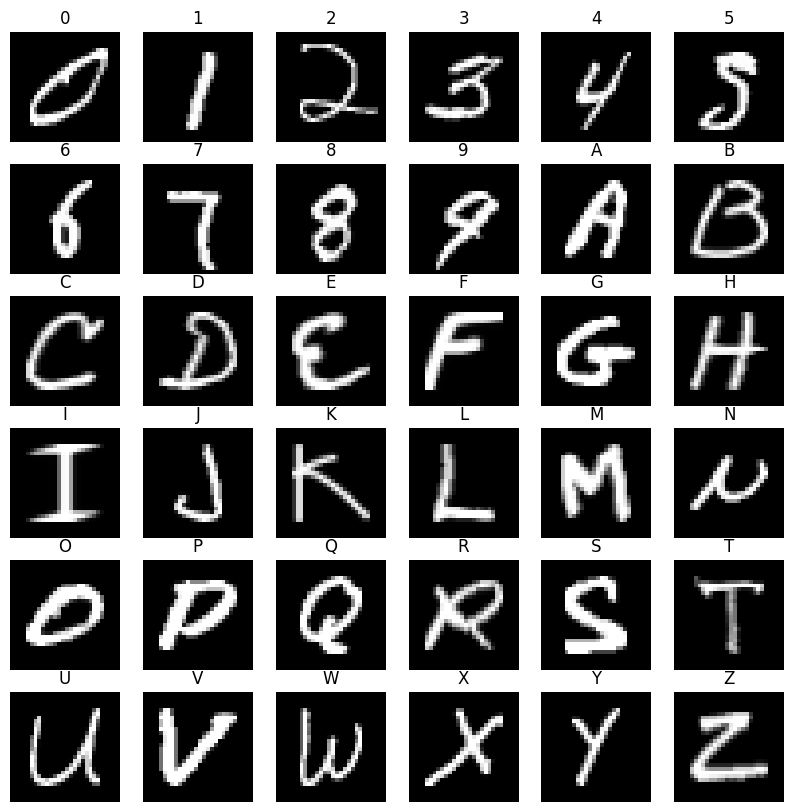

In [ ]:
#@title Loading the data, show 36 exmaples and define a dictonary to save the test accuracy
images, labels, classes = load_data(path_data,show = False)
show_examples(images,labels)
acc_test = {}

# **Training and expirements** PyTorch

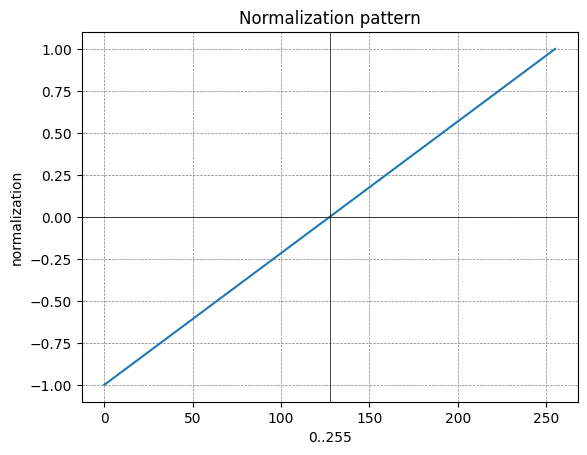

In [ ]:
# @title Setting the common parametrs such as normalization, loss, epochs
loss_function = nn.CrossEntropyLoss()
epochs_num = 50

def normalization(image):
    return image/127.5 - 1

show_normalization(normalization)

# Linear regression -

In [ ]:
# @title  Training linear regression with default Adam optimizer
batch_size = 512

train_loader, valid_loader, test_loader =  make_loaders(images = images,
                                                      labels = labels,
                                                      batch_size = batch_size,
                                                      transform = normalization,
                                                      augumentation = None,show=True)

model =  LinearRegression()

config = dict(
    epochs=epochs_num,
    model = model,
    optimizer = torch.optim.Adam(model.parameters()),
    loss = loss_function,
    batch_size=batch_size,
    learning_rate="default",
    dataset="MNIST+A_Z",
    architecture="Linear regression",
    run = f"LR adam cos",
    device = device,
    normalization = "-1..1 cos function"
)


wandb.init(project="Machine_learning_project", config=config, name=config['run'])


net = fit(config,train_loader,validloader = valid_loader)

acc_test[config["run"]] = predict(net,test_loader)

NameError: name 'images' is not defined

**Training linear regression - Experiment with SGD optimizer**
**Learning rate is being changed.**
The function to change learning rate
$lr(i) = 0.001 \cdot e^i$ | $i = [1 … 5]$


In [ ]:
# @title Train

for i in range(1,6,1):
  batch_size = 512
  lr = 0.001 * np.exp(i)
  train_transforms = transforms.Compose([
      transforms.CenterCrop((28,28)),
      transforms.Normalize(mean = (0.5), std = (0.5)),
  ])


  train_loader, valid_loader, test_loader =  make_loaders(images = images,
                                                        labels = labels,
                                                        batch_size = batch_size,
                                                        transform = normalization,
                                                        augumentation = None)

  model =  LinearRegression()

  config = dict(
      epochs=50,
      classes=36,
      model = model,
      optimizer = torch.optim.SGD(model.parameters(), lr = lr),
      loss = nn.CrossEntropyLoss(),
      batch_size=batch_size,
      learning_rate="default",
      dataset="MNIST+A_Z",
      architecture="Linear regression",
      run = f"LR SGD lr = {lr}",
      device = device,
      normalization = "-1..1"
  )


  wandb.init(project="Machine_learning_project", config=config, name=config['run'])

  net = fit(config,train_loader,validloader = valid_loader)

  wandb.finish()

In [ ]:
# @title  Training linear regression - testing batch size from 512 to 4096

for i in range(1,9,1):
  batch_size = 512 * i

  train_loader, valid_loader, test_loader =  make_loaders(images = images,
                                                        labels = labels,
                                                        batch_size = batch_size,
                                                        transform = normalization,
                                                        augumentation = None)

  model =  LinearRegression()

  config = dict(
      epochs=50,
      classes=36,
      model = model,
      optimizer = torch.optim.Adam(model.parameters()),
      loss = nn.CrossEntropyLoss(),
      batch_size=batch_size,
      learning_rate="default",
      dataset="MNIST+A_Z",
      architecture="Linear regression",
      run = f"LR batch {batch_size}",
      device = device,
      normalization = "-1..1"
  )


  wandb.init(project="Machine_learning_project", config=config, name=config['run'])

  net = fit(config,train_loader,validloader = valid_loader)

  wandb.finish()

# **Multilayer percetron**

In [ ]:
# @title  MLP with diffrent hidden layer n = 250..260

for i in range(250,261,1):
  batch_size = 512

  train_loader, valid_loader, test_loader =  make_loaders(images = images,
                                                        labels = labels,
                                                        batch_size = batch_size,
                                                        transform = normalization,
                                                        augumentation = None)

  model =  MLP(i)

  config = dict(
      epochs=50,
      classes=36,
      model = model,
      optimizer = torch.optim.Adam(model.parameters()),
      loss = nn.CrossEntropyLoss(),
      batch_size=batch_size,
      learning_rate="default",
      dataset="MNIST+A_Z",
      architecture="MLP",
      run = f"MLP n = {i}",
      device = device,
      normalization = "-1..1"
  )


  wandb.init(project="Machine_learning_project", config=config, name=config['run'])


  net = fit(config,train_loader,validloader = valid_loader)
  acc_test[config["run"]] = predict(net,test_loader)
  wandb.finish()

In [ ]:
# @title  MLP ReLU with diffrent hidden layer n = 250..260

for i in range(250,261,1):
  batch_size = 512

  train_loader, valid_loader, test_loader =  make_loaders(images = images,
                                                        labels = labels,
                                                        batch_size = batch_size,
                                                        transform = normalization,
                                                        augumentation = None)

  model =  MLP_relu(i)

  config = dict(
      epochs=50,
      classes=36,
      model = model,
      optimizer = torch.optim.Adam(model.parameters()),
      loss = nn.CrossEntropyLoss(),
      batch_size=batch_size,
      learning_rate="default",
      dataset="MNIST+A_Z",
      architecture="MLP with ReLU",
      run = f"MLP n = {i} ReLU",
      device = device,
      normalization = "-1..1"
  )


  wandb.init(project="Machine_learning_project", config=config, name=config['run'])


  net = fit(config,train_loader,validloader = valid_loader)
  acc_test[config["run"]] = predict(net,test_loader)
  wandb.finish()

# **Convolution neural network**

100%|██████████| 50/50 [01:31<00:00,  1.83s/it]


Accuracy | 0.96


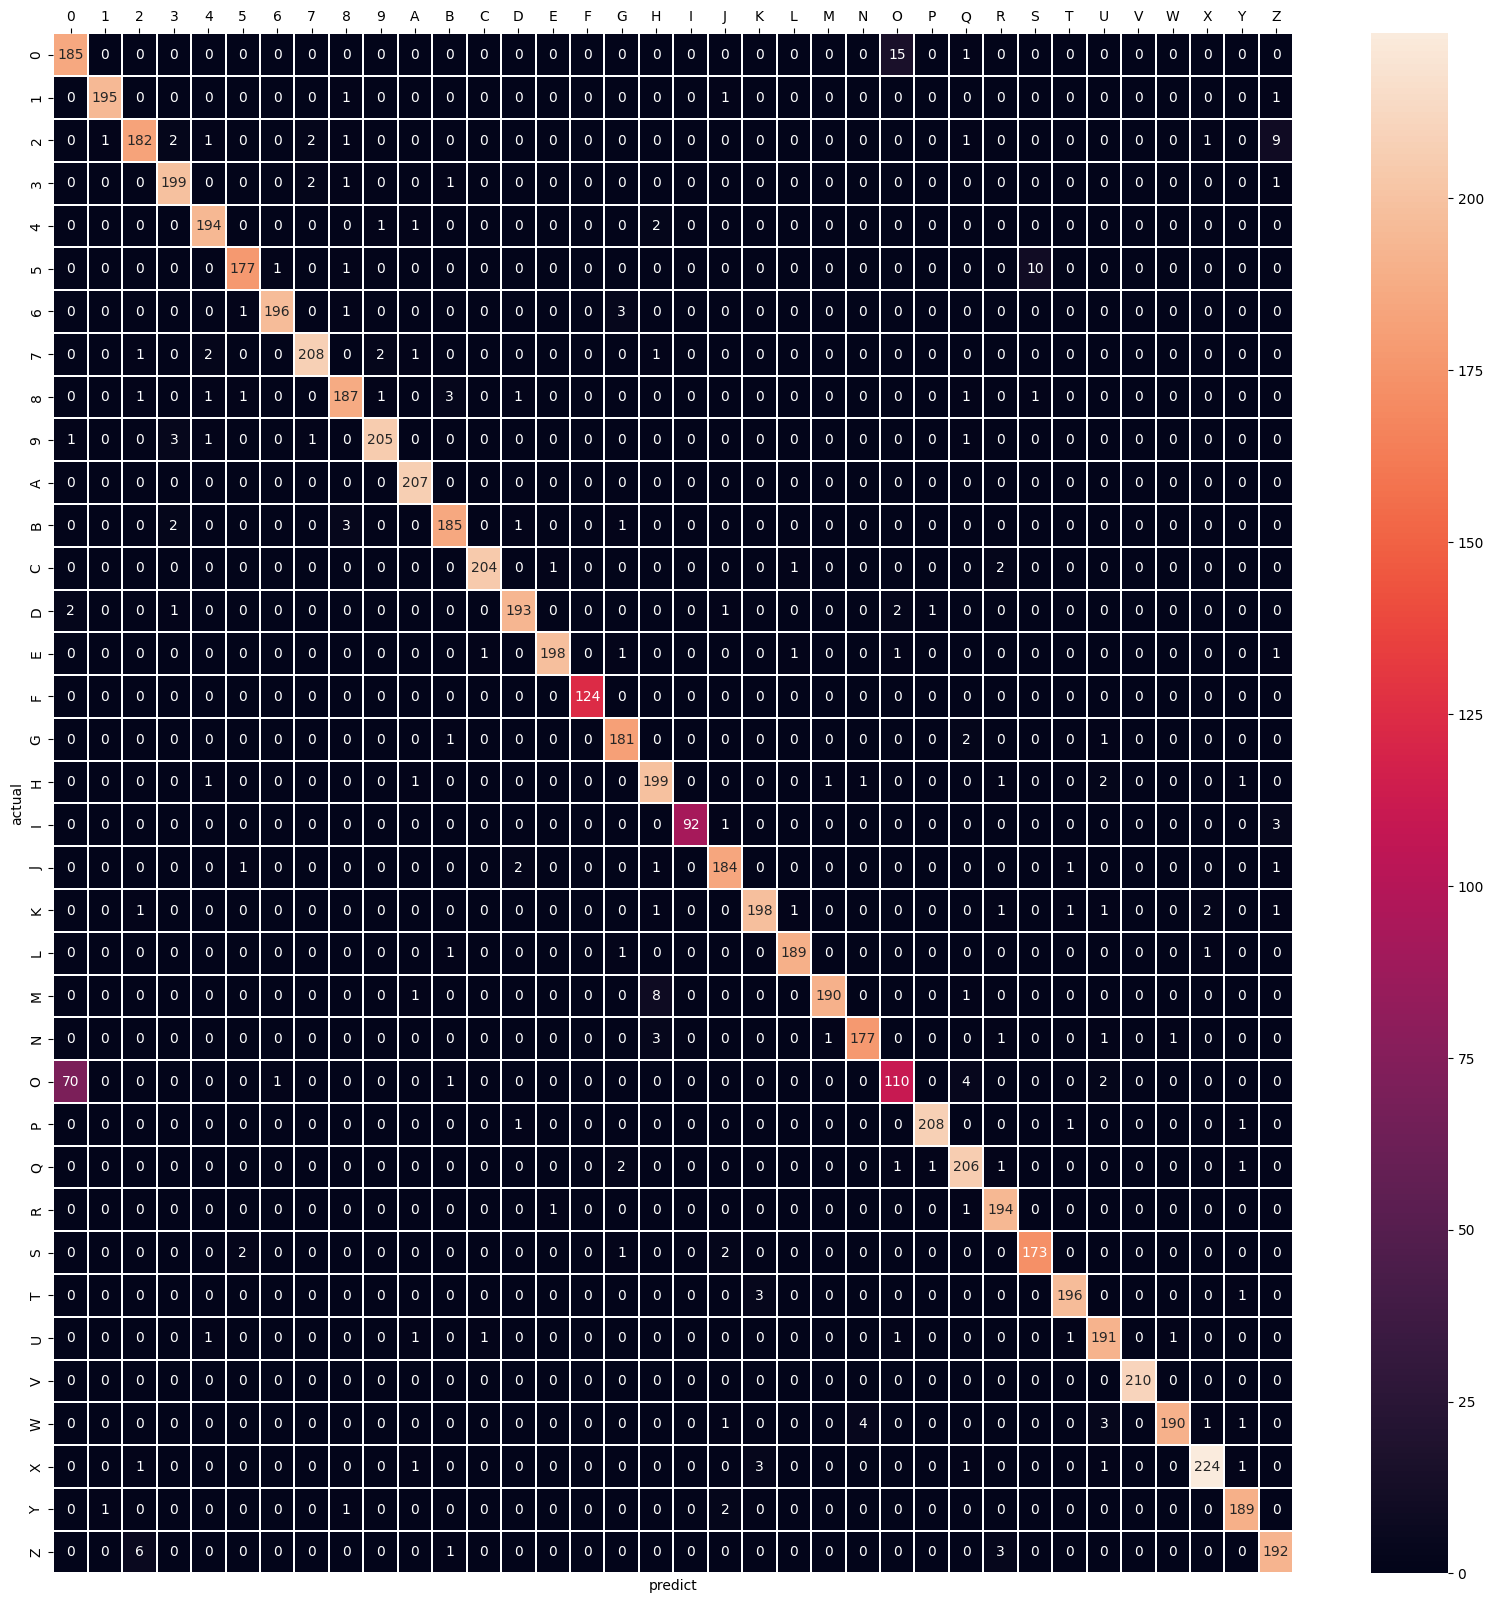

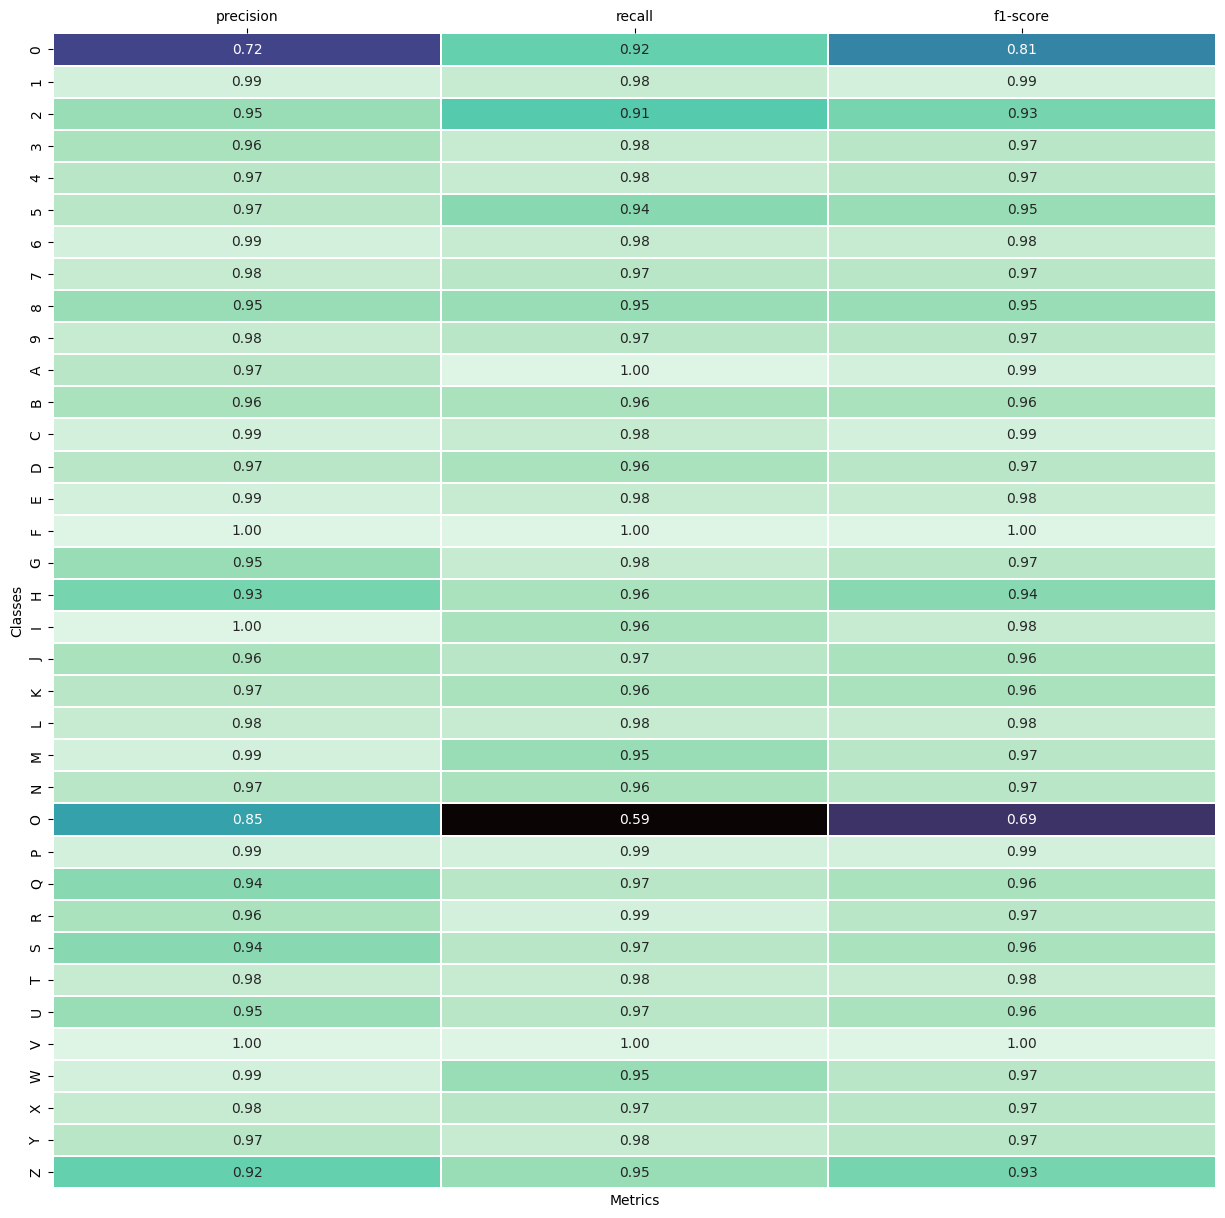

Train accuracy,▁▄▆▆▇▇▇▇▇▇██████████████████████████████
Train error,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
Valid erro,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train accuracy,0.95144
Train error,2.64908
Valid accuracy,0.95679
Valid erro,2.64832


In [ ]:
# @title  Training conv

batch_size = 512



train_loader, valid_loader, test_loader =  make_loaders(images = images,
                                                      labels = labels,
                                                      batch_size = batch_size,
                                                      transform = normalization,
                                                      augumentation = None)

model =  Conv_Avg()

config = dict(
    epochs=50,
    classes=36,
    model = model,
    optimizer = torch.optim.Adam(model.parameters()),
    loss = nn.CrossEntropyLoss(),
    batch_size=batch_size,
    learning_rate="beta = [0.5 0.9] lr = 0.001 ",
    dataset="MNIST+A_Z",
    architecture="Convolution(k =(3,3) p = (1,1))max(k = (2,2)) 1f->16f  max 16f->32f max",
    run = f"Conv -1..1 diff adam ",
    device = device,
    normalization = "0..1"
)


wandb.init(project="Machine_learning_project", config=config, name=config['run'])


net = fit(config,train_loader,validloader = valid_loader)
acc_test[config["run"]] = predict(net,test_loader)

wandb.finish()

In [ ]:
# @title  Training conv_2

batch_size = 512



train_loader, valid_loader, test_loader =  make_loaders(images = images,
                                                      labels = labels,
                                                      batch_size = batch_size,
                                                      transform = normalization,
                                                      augumentation = None)



model =  Conv_2()

config = dict(
    epochs=50,
    classes=36,
    model = model,
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001),
    loss = nn.CrossEntropyLoss(),
    batch_size=batch_size,
    learning_rate="default",
    dataset="MNIST+A_Z",
    architecture="Convolution(k =(3,3) p = (1,1)) avg(k = (2,2)) 1f->16f  avg 16f->32f avg",
    run = f"Conv_2 maxpooling",
    device = device,
    normalization = "-1..1"
)


wandb.init(project="Machine_learning_project", config=config, name=config['run'])


net = fit(config,train_loader,validloader = valid_loader)
acc_test[config["run"]] = predict(net,test_loader)

wandb.finish()

In [ ]:
# @title  Training conv improving accuracy augumenation

batch_size = 512


augumentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.2, 0.5), ratio=(0.1, 0.3), antialias=True),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomVerticalFlip(p=0.25),
])



train_loader, valid_loader, test_loader =  make_loaders(images = images,
                                                      labels = labels,
                                                      batch_size = batch_size,
                                                      transform = normalization,
                                                      augumentation = augumentation_transform)

model =  Conv()

config = dict(
    epochs=50,
    classes=36,
    model = model,
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001),
    loss = nn.CrossEntropyLoss(),
    batch_size=batch_size,
    learning_rate="default",
    dataset="MNIST+A_Z",
    architecture="Convolution(k =(3,3) p = (1,1))avg(k = (2,2)) 1f->16f  avg 16f->32f avg",
    run = f"Conv improving accuracy (augumentation s)",
    device = device,
    normalization = "-1..1"
)


wandb.init(project="Machine_learning_project", config=config, name=config['run'])


net = fit(config,train_loader,validloader = valid_loader)
acc_test[config["run"]] = predict(net,test_loader)

wandb.finish()

In [ ]:
# @title  Training conv improving accuracy augumenation less augumentation

batch_size = 512

augumentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomVerticalFlip(p=0.25),
])



train_loader, valid_loader, test_loader =  make_loaders(images = images,
                                                      labels = labels,
                                                      batch_size = batch_size,
                                                      transform = normalization,
                                                      augumentation = augumentation_transform)

model =  Conv()

config = dict(
    epochs=50,
    classes=36,
    model = model,
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001),
    loss = nn.CrossEntropyLoss(),
    batch_size=batch_size,
    learning_rate="default",
    dataset="MNIST+A_Z",
    architecture="Convolution(k =(3,3) p = (1,1))avg(k = (2,2)) 1f->16f  avg 16f->32f avg",
    run = f"Conv improving accuracy (augumentation s)",
    device = device,
    normalization = "-1..1"
)


wandb.init(project="Machine_learning_project", config=config, name=config['run'])


net = fit(config,train_loader,validloader = valid_loader)
acc_test[config["run"]] = predict(net,test_loader)

wandb.finish()

In [ ]:
# @title  Training conv improving accuracy augumenation less less augumentation

batch_size = 512

augumentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomVerticalFlip(p=0.1),
])



train_loader, valid_loader, test_loader =  make_loaders(images = images,
                                                      labels = labels,
                                                      batch_size = batch_size,
                                                      transform = normalization,
                                                      augumentation = augumentation_transform)

model =  Conv()

config = dict(
    epochs=50,
    classes=36,
    model = model,
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001),
    loss = nn.CrossEntropyLoss(),
    batch_size=batch_size,
    learning_rate="default",
    dataset="MNIST+A_Z",
    architecture="Convolution(k =(3,3) p = (1,1))avg(k = (2,2)) 1f->16f  avg 16f->32f avg",
    run = f"Conv improving accuracy (augumentation VS)",
    device = device,
    normalization = "-1..1"
)


wandb.init(project="Machine_learning_project", config=config, name=config['run'])


net = fit(config,train_loader,validloader = valid_loader)
acc_test[config["run"]] = predict(net,test_loader)

wandb.finish()

In [ ]:
# @title  Training conv improving accuracy transfer learning without data augumetation

batch_size = 512


train_loader, valid_loader, test_loader =  make_loaders(images = images,
                                                      labels = labels,
                                                      batch_size = batch_size,
                                                      transform = normalization,
                                                      augumentation = None)

model =  Conv()
model.load_state_dict(torch.load("/content/drive/MyDrive/Machnie_learning_project/model/Conv improving accuracy (augumentation VS)/Conv improving accuracy (augumentation VS)_epoch_49.pth"))
model.out_layer = weight_init(nn.Linear(64,36))

config = dict(
    epochs=50,
    classes=36,
    model = model,
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001),
    loss = nn.CrossEntropyLoss(),
    batch_size=batch_size,
    learning_rate="default",
    dataset="MNIST+A_Z",
    architecture="Convolution(k =(3,3) p = (1,1))avg(k = (2,2)) 1f->16f  avg 16f->32f avg",
    run = f"Conv improving accuracy transfer learning without data augumetation",
    device = device,
    normalization = "-1..1"
)


wandb.init(project="Machine_learning_project", config=config, name=config['run'])


net = fit(config,train_loader,validloader = valid_loader)
acc_test[config["run"]] = predict(net,test_loader)

wandb.finish()

In [ ]:
# @title  Training LeNet

batch_size = 512



train_loader, valid_loader, test_loader =  make_loaders(images = images,
                                                      labels = labels,
                                                      batch_size = batch_size,
                                                      transform = normalization,
                                                      augumentation = None)

model =  LeNet()

config = dict(
    epochs=50,
    classes=36,
    model = model,
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001),
    loss = nn.CrossEntropyLoss(),
    batch_size=batch_size,
    learning_rate="default",
    dataset="MNIST+A_Z",
    architecture="LeNet",
    run = f"LeNet ",
    device = device,
    normalization = "-1..1"
)


wandb.init(project="Machine_learning_project", config=config, name=config['run'])


net = fit(config,train_loader,validloader = valid_loader)
predict(net,test_loader)

wandb.finish()

# **Improving the accuracy **

In [ ]:
# @title The CNN model to determind if it is 0 or O

class zero_or_o(nn.Module):
    def __init__(self):
        super(zero_or_o, self).__init__()

        self.pooling = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))

        self.conv_1 = nn.Conv2d(1,16,kernel_size=(3,3),stride=(1,1),padding=(1,1))
        self.conv_2 = nn.Conv2d(16,16,kernel_size=(3,3),stride=(1,1),padding=(1,1))

        self.in_layer = weight_init(nn.Linear(1568,256))
        self.hidden_layer = weight_init(nn.Linear(256,64))
        self.out_layer = weight_init(nn.Linear(64,2))
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pooling(self.relu(self.conv_1(x)))
        x = self.pooling(self.relu(self.conv_2(x)))
        x = self.flatten(x)
        x = self.drop(x)
        x = self.relu(self.in_layer(x))
        x = self.relu(self.hidden_layer(x))
        x = self.sigmoid(self.out_layer(x))

        return x

In [ ]:
# @title getting only O and 0
zero_index = [i for i,j in enumerate(labels) if j == 0]
o_index = [i for i,j in enumerate(labels) if j == 24]

zero_o_labels = []
zero_o_images = []
for i in zero_index:
  zero_o_labels.append(0)
  zero_o_images.append(images[i,:])

for i in o_index:
  zero_o_labels.append(1)
  zero_o_images.append(images[i,:])


In [ ]:
# @title Combine two Conv net
def predict_o_0(testloader,short = False):
    net.eval()
    net_o.eval()
    real = torch.tensor(())
    pred = torch.tensor(())
    for image, label in testloader:
        image = image.to(device)
        output = net(image)
        output = torch.argmax(output, dim = 1)
        for i,sample in enumerate(output):
          if (sample == 0) or (sample == 24):
            out = net_o(image[i].unsqueeze(0))
            if (torch.argmax(out).item() == 0):
              output[i] = 0
            if (torch.argmax(out).item() == 1):
              output[i] = 24
        output = output.cpu()
        label = label.cpu()
        real = torch.cat((real,label))
        pred = torch.cat((pred,output))

    raw = classification_report(real,pred)
    splited = raw.split("\n")

    acc = [element for element in splited[39].split(' ') if element != '']

    print(f"Accuracy | {float(acc[1])}")
    matrix = confusion_matrix(real,pred)
    fig, ax = plt.subplots(figsize=(20, 20))

    ax = sns.heatmap(matrix,linewidth=.2,xticklabels=classes,yticklabels = classes,annot=True,fmt=".0f")
    ax.set(xlabel="predict", ylabel="actual")
    ax.xaxis.tick_top()
    plt.show()

    final = {}
    for i in range(2,38,1):
      individual = splited[i].split(" ")
      cleared = [element for element in individual if element != '']
      cleared[0] = classes[int(float(cleared[0]))]
      final[cleared[0]] = cleared[1:-1]

    keys = []
    values = []
    for key, value in final.items():
        keys.append(key)
        for i in range(3):
          value[i] = float(value[i])
        values.append(value)

    fig, ax = plt.subplots(figsize=(15, 15))

    ax = sns.heatmap(values,linewidth=0.1,xticklabels=['precision','recall','f1-score'],yticklabels = keys,annot=True,fmt=".2f",cmap="mako", cbar = False)
    ax.set(xlabel="Metrics", ylabel="Classes")
    ax.xaxis.tick_top()
    plt.show()


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Accuracy | 0.97


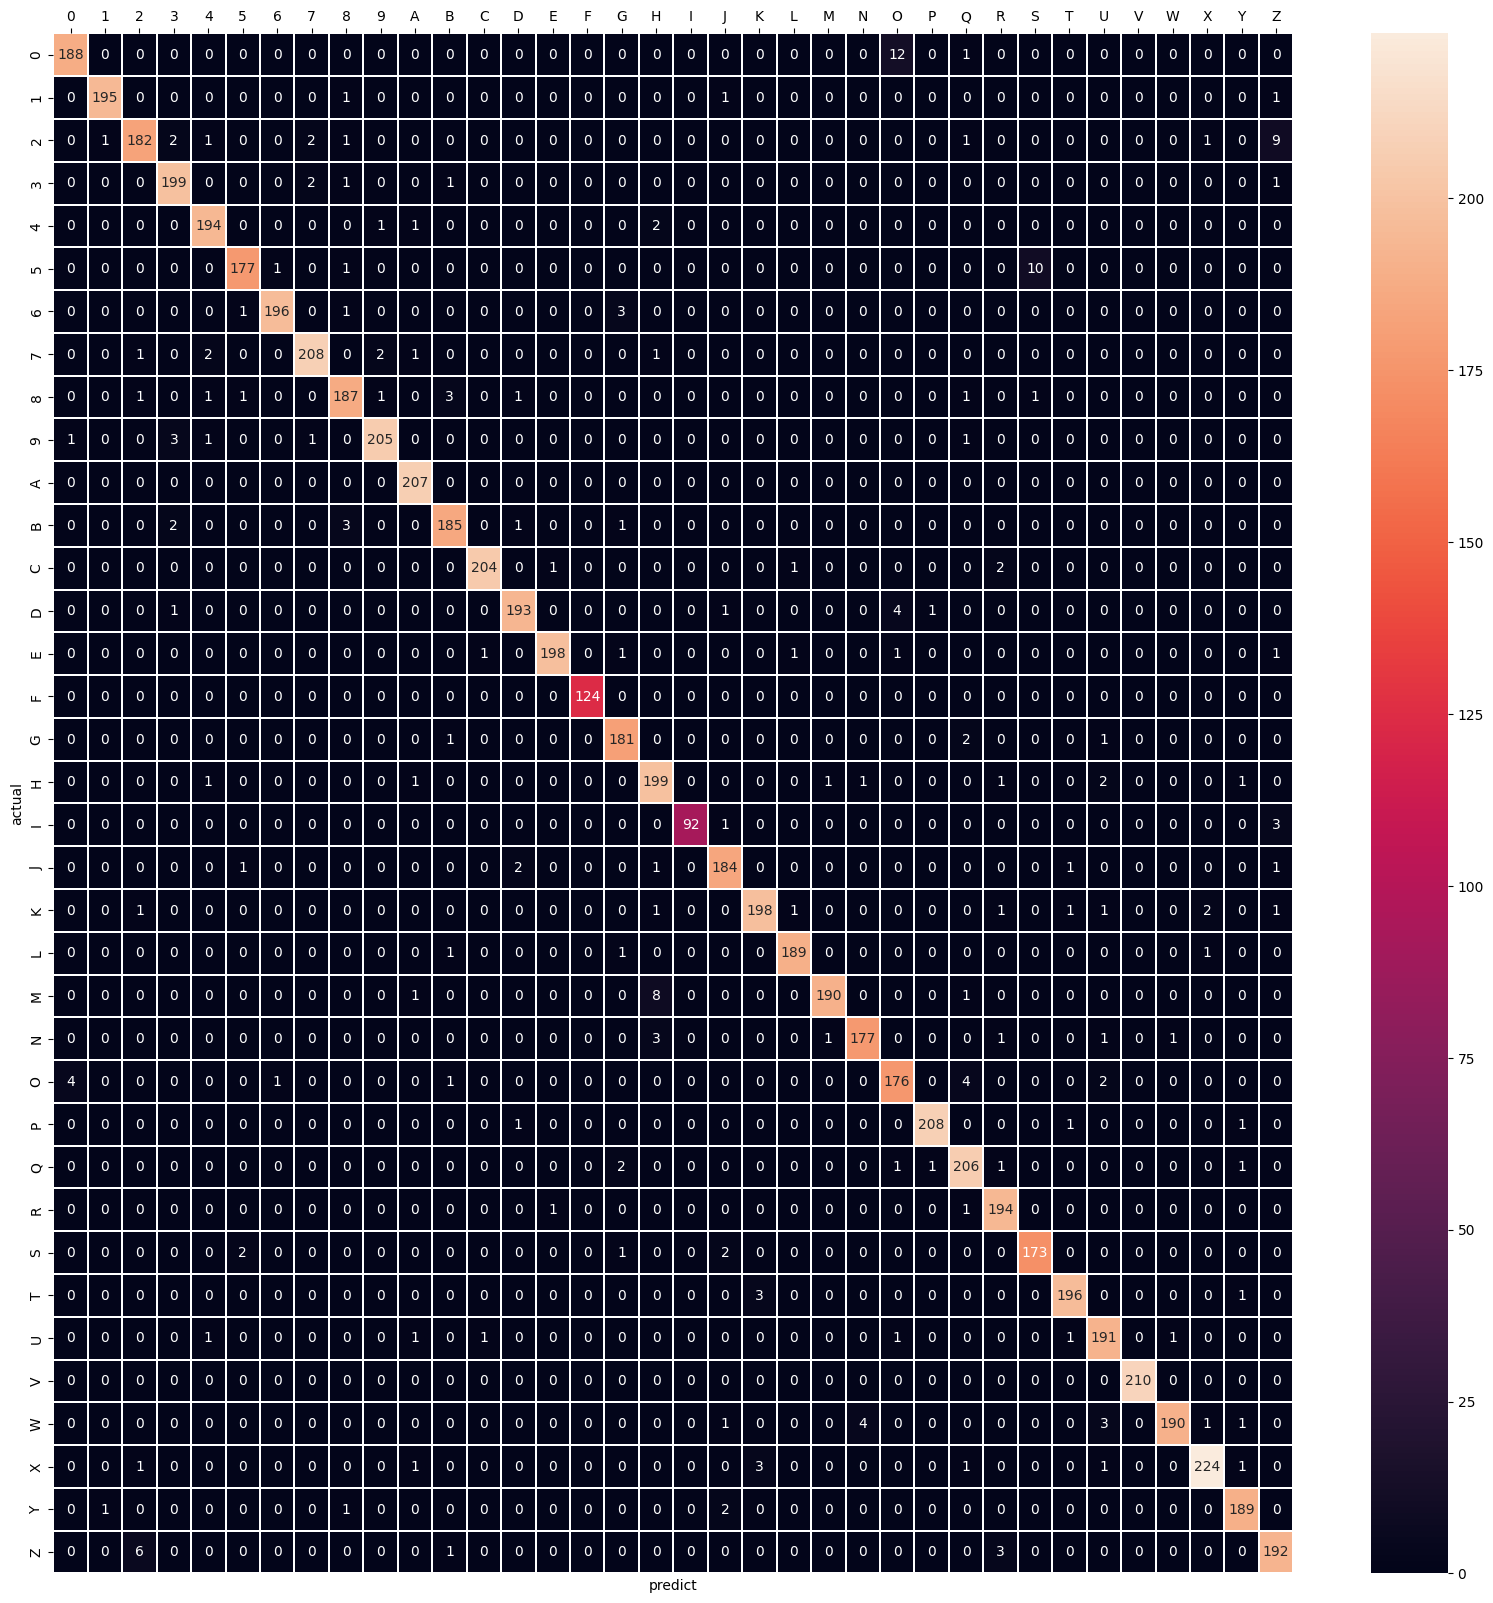

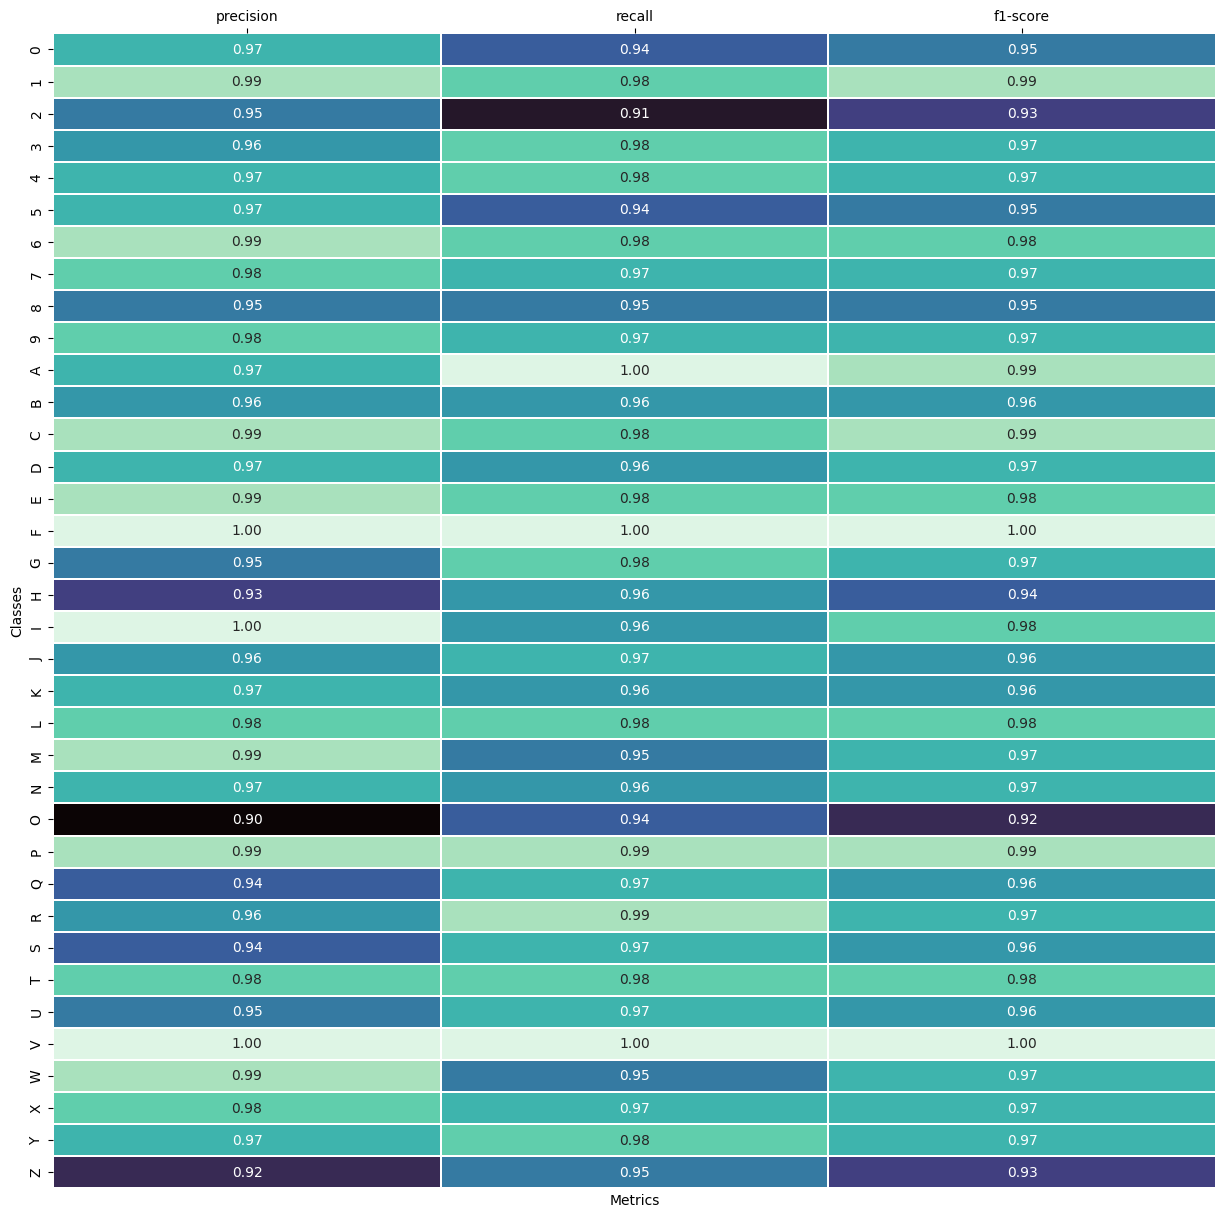

Train accuracy,▁▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████
Train error,█▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Valid accuracy,▁▅▅▅▆▄▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇█▇▇▆▇▇▇▇██▇█▇███
Valid erro,█▅▄▄▃▅▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▃▁▂▂▂▁▁▁▁▂▁▁▁
Train accuracy,0.90954
Train error,0.39893
Valid accuracy,0.912
Valid erro,0.39735


In [ ]:
# @title train sub Conv
batch_size = 50



train_loader_o, valid_loader_o, test_loader_o =  make_loaders(images = zero_o_images,
                                                      labels = zero_o_labels,
                                                      batch_size = batch_size,
                                                      transform = normalization,
                                                      augumentation = None)

model =  zero_or_o()

config = dict(
    epochs=50,
    classes=36,
    model = model,
    optimizer = torch.optim.Adam(model.parameters()),
    loss = nn.CrossEntropyLoss(),
    batch_size=batch_size,
    learning_rate="default",
    dataset="o or 0",
    architecture="Convolution(k =(3,3) p = (1,1))avg(k = (2,2)) 1f->16f  avg 16f->32f avg",
    run = f"Conv for o or 0 ",
    device = device,
    normalization = "0..1"
)


wandb.init(project="Machine_learning_project", config=config, name=config['run'])


net_o = fit(config,train_loader_o,validloader = valid_loader_o)
predict_o_0(test_loader)

wandb.finish()

# **Loading the model if it is necessary**

In [ ]:
# @title load the model back to notebook from goggle drive
loaded_model = Conv_Max()

# Specify the file path where the model is saved
model_state_dict = torch.load("/content/drive/MyDrive/Machnie_learning_project/model/Conv_2 maxpooling/Conv_2 maxpooling_epoch_49.pth")

# Load the saved state dictionary into the model
loaded_model.load_state_dict(model_state_dict)

# Put the model in evaluation mode (if needed)
loaded_model.eval()

print("Model loaded successfully.")


Model loaded successfully.


In [ ]:
# @title Test the model
batch_size = 512



train_loader, valid_loader, test_loader =  make_loaders(images = images,
                                                      labels = labels,
                                                      batch_size = batch_size,
                                                      transform = normalization,
                                                      augumentation = None)
loaded_model.to(device)
predict(loaded_model,test_loader)

# **Tensorflow**

In [ ]:
# @title import tensorflow
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.optimizers import *

In [ ]:
# @title Prepare data
images_train_np = np.reshape(images,(-1,28,28,1))
images_train_np = normalization(images_train_np)
images_train, images_test, labels_train, labels_test = train_test_split(images_train_np, labels, test_size=0.2, random_state=42)
images_train, images_valid, labels_train, labels_valid = train_test_split(images_train, labels_train, test_size=0.1, random_state=42)
input_shape = (None,28,28,1)
print("shape before expand dim:",images_train.shape)

shape before expand dim: (50603, 28, 28, 1)


In [ ]:
# @title create dataset
train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
val_dataset = tf.data.Dataset.from_tensor_slices((images_valid, labels_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((images_test, labels_test))

batch_size = 512


train_dataset = train_dataset.shuffle(buffer_size=len(images_train)).batch(batch_size)

val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [ ]:
# @title define the model on tf
class Conv_tf(tf.keras.Model):
    def __init__(self):
        super(Conv_tf, self).__init__()

        self.pooling = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))

        self.conv_1 = layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')
        self.conv_2 = layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')

        self.flatten = layers.Flatten()
        self.in_layer = layers.Dense(256, activation='relu')
        self.hidden_layer = layers.Dense(64, activation='relu')
        self.out_layer = layers.Dense(36, activation='sigmoid')
        self.dropout = layers.Dropout(0.5)

    def call(self, x):
        x = self.pooling(tf.nn.relu(self.conv_1(x)))
        x = self.pooling(tf.nn.relu(self.conv_2(x)))
        x = self.flatten(x)
        x = self.dropout(x)
        x = tf.nn.relu(self.in_layer(x))
        x = tf.nn.relu(self.hidden_layer(x))
        x = self.out_layer(x)

        return x

# Create an instance of the Conv model
model = Conv_tf()

# Print the model summary
model.build(input_shape)
model.summary()


In [ ]:
# @title config file for wandb
config = dict(
  epochs=50,
  classes=36,
  model = model,
  optimizer = "Adam",
  loss = nn.CrossEntropyLoss(),
  batch_size=512,
  learning_rate="default",
  dataset="MNIST+A_Z",
  architecture="Conv max tf",
  run = f"Conv tf",
  device = "Automregognition",
  normalization = "-1..1"
)

In [ ]:
# @title train
model = Conv_tf()

optimizer = optimizers.Adam()
loss_function = losses.SparseCategoricalCrossentropy()

train_loss_metric = tf.metrics.Mean(name='train_loss')
train_accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name='train_accuracy')

validation_loss_metric = tf.metrics.Mean(name='validation_loss')
validation_accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name='validation_accuracy')


num_epochs = 50

wandb.init(project="Machine_learning_project", config=config, name=config['run'])
for epoch in range(num_epochs):
    for batch in train_dataset:
        images, labels = batch
        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = loss_function(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss_metric(loss)
        train_accuracy_metric(labels, predictions)

    wandb.log({
            "Train error": train_loss_metric.result(),
            "Train accuracy": train_accuracy_metric.result()
        }, step = epoch)

    for batch in val_dataset:
        images, labels = batch
        predictions = model(images)
        loss = loss_function(labels, predictions)
        validation_loss_metric(loss)
        validation_accuracy_metric(labels, predictions)

    wandb.log({
            "Valid erro": validation_loss_metric.result(),
            "Valid accuracy": validation_accuracy_metric.result()
        },step = epoch + 1)


    train_loss_metric.reset_states()
    train_accuracy_metric.reset_states()
    validation_loss_metric.reset_states()
    validation_accuracy_metric.reset_states()

wandb.finish()

# **Load the JSON file **

In [ ]:
import json

# Specify the path to your JSON file
json_file_path = '/content/drive/MyDrive/Machnie_learning_project/data/accuracy.json'

# Open the file and load the JSON data
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Now 'data' contains the content of the JSON file
print(data)


{'LR adam log norm': 0.76, 'LR batch 512': 0.77, 'LR batch 1024': 0.77, 'LR batch 1536': 0.76, 'LR batch 2048': 0.77, 'LR batch 2560': 0.75, 'LR batch 3072': 0.76, 'LR batch 3584': 0.76, 'LR batch 4096': 0.75, 'LR Adam': 0.77, 'LR SGD': 0.32, 'LR SGD lr = 0.002718281828459045': 0.58, 'LR SGD lr = 0.007389056098930651': 0.67, 'LR SGD lr = 0.02008553692318767': 0.71, 'LR SGD lr = 0.054598150033144235': 0.74, 'LR SGD lr = 0.1484131591025766': 0.75, 'MLP n = 250': 0.66, 'MLP n = 251': 0.69, 'MLP n = 252': 0.67, 'MLP n = 253': 0.67, 'MLP n = 254': 0.69, 'MLP n = 255': 0.68, 'MLP n = 256': 0.68, 'MLP n = 257': 0.64, 'MLP n = 258': 0.61, 'MLP n = 259': 0.66, 'MLP n = 260': 0.66, 'MLP n = 250 ReLU': 0.93, 'MLP n = 251 ReLU': 0.93, 'MLP n = 252 ReLU': 0.92, 'MLP n = 253 ReLU': 0.93, 'MLP n = 254 ReLU': 0.93, 'MLP n = 255 ReLU': 0.93, 'MLP n = 256 ReLU': 0.92, 'MLP n = 257 ReLU': 0.93, 'MLP n = 258 ReLU': 0.93, 'MLP n = 259 ReLU': 0.93, 'MLP n = 260 ReLU': 0.93, 'Conv ': 0.96, 'Conv_2 maxpooling

In [ ]:
data["LeNet"] = 0.93

In [ ]:
k = ['LR adam log norm', 'LR SGD', 'MLP n = 250', 'MLP n = 251', 'MLP n = 252', 'MLP n = 253', 'MLP n = 254', 'MLP n = 255', 'MLP n = 256', 'MLP n = 257', 'MLP n = 258', 'MLP n = 259', 'MLP n = 260', 'MLP n = 250 ReLU', 'MLP n = 251 ReLU', 'MLP n = 252 ReLU', 'MLP n = 253 ReLU', 'MLP n = 254 ReLU', 'MLP n = 255 ReLU', 'MLP n = 256 ReLU', 'MLP n = 257 ReLU', 'MLP n = 258 ReLU', 'MLP n = 259 ReLU', 'MLP n = 260 ReLU', 'Conv ', 'Conv_2 maxpooling', 'Conv improving accuracy (augumentation s)']
for i in k:
  del data[i]

In [ ]:
data["Conv MAXPOOL"] = data['Conv_2 maxpooling']
del data['Conv_2 maxpooling']

In [ ]:
data

{'LR batch 512': 0.77,
 'LR batch 1024': 0.77,
 'LR batch 1536': 0.76,
 'LR batch 2048': 0.77,
 'LR batch 2560': 0.75,
 'LR batch 3072': 0.76,
 'LR batch 3584': 0.76,
 'LR batch 4096': 0.75,
 'LR Adam': 0.77,
 'LR SGD lr = 0.002': 0.58,
 'LR SGD lr = 0.0074': 0.67,
 'LR SGD lr = 0.02': 0.71,
 'LR SGD lr = 0.055': 0.74,
 'LR SGD lr = 0.15': 0.75}

In [ ]:
h = ['LR SGD lr = 0.002718281828459045', 'LR SGD lr = 0.007389056098930651', 'LR SGD lr = 0.02008553692318767', 'LR SGD lr = 0.054598150033144235', 'LR SGD lr = 0.1484131591025766']
h_2 = ['LR SGD lr = 0.002', 'LR SGD lr = 0.0074', 'LR SGD lr = 0.02', 'LR SGD lr = 0.055', 'LR SGD lr = 0.15']
for i,a in enumerate(h):
  data[h_2[i]] = data[a]
  del data[a]

In [ ]:
del data["LeNet"]

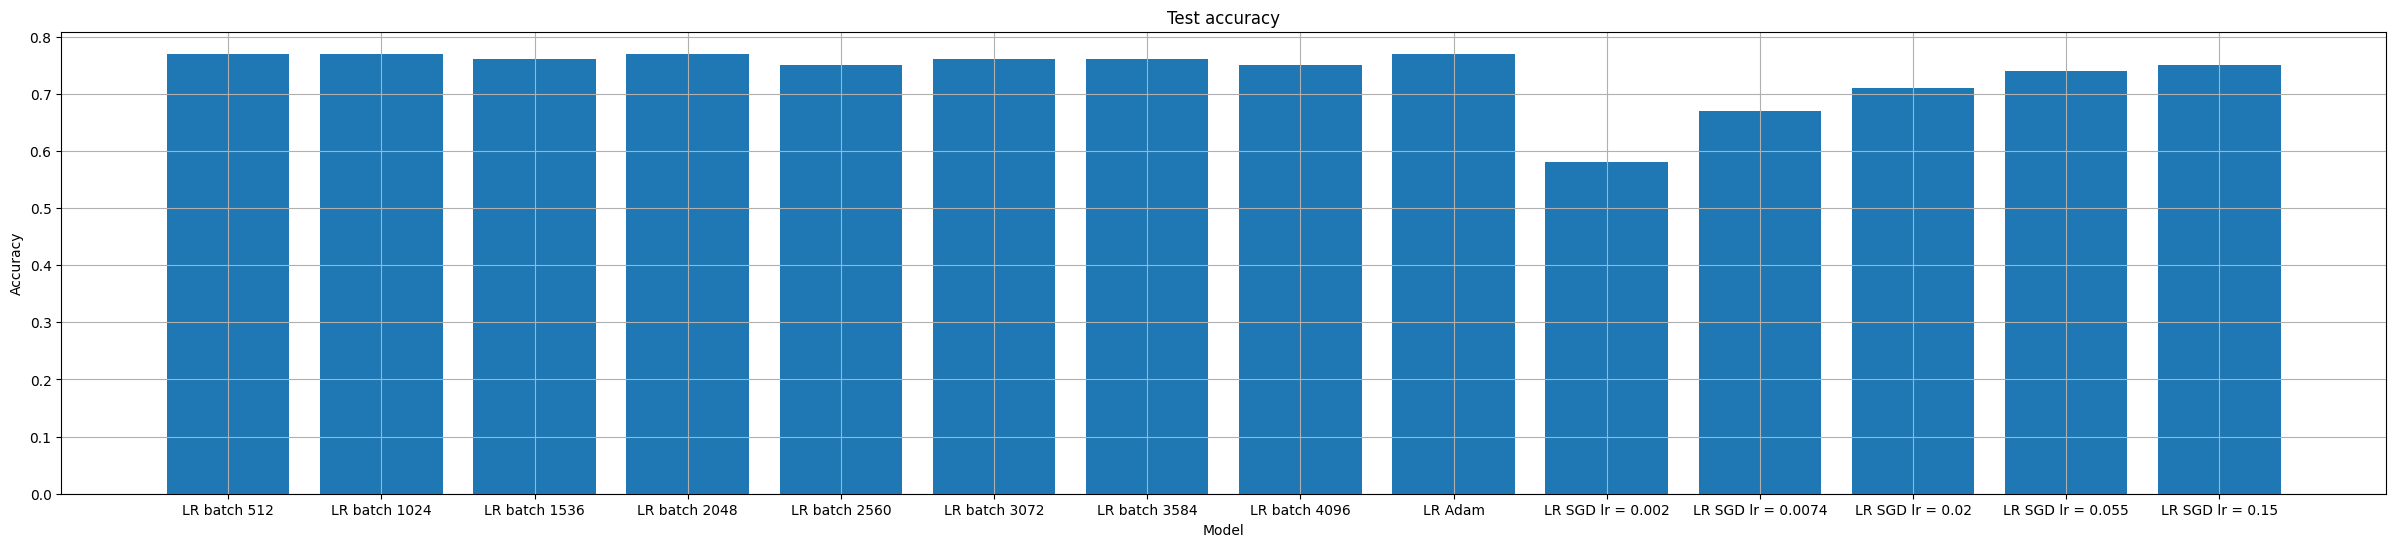

In [ ]:
import matplotlib.pyplot as plt

# Extract keys and values from the dictionary
keys = list(data.keys())
values = list(data.values())

plt.figure(figsize=(30, 6))
# Plot the histogram
plt.bar(keys, values)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Test accuracy')
plt.grid()

# Display the plot
plt.show()
